现在我们将使用DyPy模拟一群玩家进行囚徒困境的游戏，看看自然选择是否有利于叛逃。要做到这一点，我们首先要设置游戏。这涉及到指定策略、平衡点和与之相关的报酬矩阵。以下16行代码是用来准备博弈的

给定代码定义了一个名为 SymmetricNPlayerGame 的类，它继承自 Game 类。该类提供了一个N人博弈的逻辑，其中每个玩家从相同的策略集中选择。

类构造函数接受几个参数：

payoff_matrix：一个二维列表，表示每个玩家的收益矩阵。由于这是对称博弈，因此这个矩阵应该是对称的。
n：游戏中玩家类型的数量，对于一个两人对称博弈来说，通常为1。
bias_strength、bias_scale 和 equilibrium_tolerance 为可选参数，分别表示偏差强度、偏差规模和平衡容忍度。
在构造函数中，如果 STRATEGY_LABELS 不为空，会将其复制n次作为新的 STRATEGY_LABELS。然后，将给定的 payoff_matrix 转置后追加到原矩阵后面，构成一个包含两个矩阵的列表。最后，通过调用父类的构造函数，初始化 SymmetricNPlayerGame 的实例。

In [1]:
from games.game import SymmetricNPlayerGame
# Class that defines the Prisoners’ Dilemma game.
class PrisonersDilemma(SymmetricNPlayerGame):
    DEFAULT_PARAMS = dict(R = 3, S = 0, T = 5, P = 1, bias_strength = 0)# List of strategies
    STRATEGY_LABELS = ('合作者', '反叛者')# List of equilibria
    EQUILIBRIA_LABELS = ('Cooperation', 'Defection')
    
    def __init__(self, R, S, T, P, bias_strength): #Define the payoff matrix
        payoff_matrix = ((R, S), (T, P))
        super(PrisonersDilemma, self).__init__(payoff_matrix, 1, bias_strength)
        
    @ classmethod
    # Function that defines the equilibria
    def classify(cls, params, state, tolerance):
        threshold = 1 - tolerance
        if state[0][0] > threshold:
            return 0# Cooperate
        elif state[0][1] > threshold:
            return 1# Defect
        else :
            return super(PrisonersDilemma, cls).classify(params, state, tolerance)

In [2]:
print(PrisonersDilemma)

<class '__main__.PrisonersDilemma'>


这段代码定义了一个名为 PD 的类，它继承自 SymmetricNPlayerGame 类。PD 类代表了一个囚徒困境博弈。

类变量 `DEFAULT_PARAMS` 是一个字典，包含囚徒困境博弈中的四个参数 R、S、T 和 P，以及偏见强度 bias_strength 和偏见规模 bias_scale。这些参数将在 `__init__` 方法中使用。

`STRATEGY_LABELS` 是一个元组，它包含博弈中使用的两种策略标签：“合作”和“背叛”。

`EQUILIBRIA_LABELS` 是一个元组，它包含两种平衡状态的标签：“合作”和“背叛”。

`__init__` 方法使用给定的 R、S、T、P、bias_strength 和 bias_scale 参数初始化一个 2x2 的元组 `payoff_matrix`，并将其传递给父类 SymmetricNPlayerGame 的构造函数。同时，传递了参数1表示仅有一种类型的玩家在游戏中参与。

`classify` 方法根据给定的参数和当前状态，判断当前策略处于哪个平衡状态。当玩家采取“合作”时，收益为 R（reward）；当玩家采取“背叛”时，收益为 T（temptation）。当对手采取“合作”时，收益为 S（sucker's payoff）；当对手采取“背叛”时，收益为 P（punishment）。判断状态的方法是，如果玩家采取“合作”策略的比例大于等于 
$$
1-\text{tolerance}
$$
，则返回0，表示当前处于“合作”状态；如果玩家采取“背叛”策略的比例大于等于
$$
1-\text{tolerance}
$$
，则返回1，表示当前处于“背叛”状态；否则，调用父类 SymmetricNPlayerGame 的 `classify` 方法进行分类。

In [3]:
# import matplotlib
# print(matplotlib.matplotlib_fname())

# #对博弈动态的单一模拟

In [4]:
#导入中文字体包
from matplotlib import font_manager
font_manager.fontManager.addfont('/Users/pu/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/SimHei.ttf')

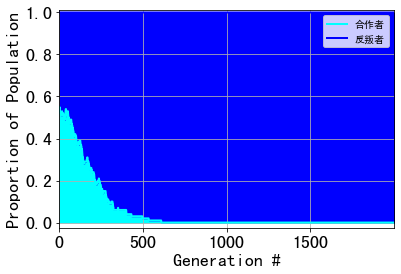

In [5]:
# 使用Moran迭代2000次的策略
from wrapper import GameDynamicsWrapper
from dynamics.moran import Moran
s = GameDynamicsWrapper(PrisonersDilemma, Moran)
s.simulate(num_gens = 2000, pop_size = 100, graph = dict(area = True, options = ['smallfont']))
# s.simulate(num_gens=100,pop_size=100,graph=dict(area=True,options=['smallfont']))

在许多情况下，我们希望多次运行模拟，以检查在初始条件发生变化或由于动态的固有随机性而产生的结果的稳健性。
博弈也可能有多个均衡，在这种情况下，用户可能会对人口在每个均衡中度过的迭代的比例感兴趣。
由于这些原因，我们提供了 "simulate many "的方法，在这个方法中，模拟的多次迭代被运行，并返回每个结果均衡的频率。
如果系统不在使用分类命令确定的状态的 "容忍度 "范围内，模拟会返回 "未分类"。
当进行多次模拟时，它们会自动在所有可用的核心上并行化。
我们现在使用 "simulate many "和随机的Moran  dynamic，以表明即使在存在随机性的情况下，玩囚徒困境的群体也会稳定在叛逃状态。

# #博弈的动态模拟多次迭代 Multiple iterations of a simulation of the game’s dynamic

simulate_many这段代码是一个类的方法，用于模拟博弈，多次迭代，计算出每个策略均衡出现的频率。具体来说，它将调用simulate方法num_iterations次，每次模拟num_gens代，然后平均频率，以得出策略均衡的结果。该方法在计算时进行了并行化处理。

参数说明：

num_iterations：模拟的次数。
num_gens：每次模拟运行的代数。
pop_size：总人口数量。
start_state：每个玩家策略的初始分布，可以是列表或None。
graph：图形的类型，如果不需要图形则为false。
histogram：如果为True，则绘制最终人口数量的直方图。graph和histogram不能同时为True。
return_labeled：是否应对返回的归类均衡分布进行标记。
parallelize：是否并行计算，默认为True。
class_end：如果为False，则对所有代进行归类，如果为True，则只对最后一代进行归类。
frac_invasions：给定的模拟是否计算某一策略的侵略程度分数。
strategy_indx：要计算侵略程度分数的策略的索引。
返回值是每个策略均衡出现的频率。

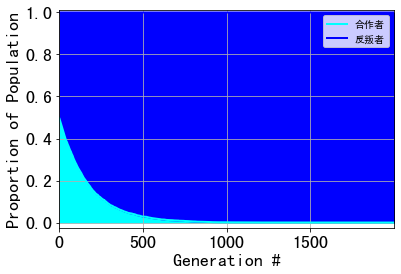

{'Defection': 1.0}

In [7]:
# 使用Moran迭代2000次，平均100次记录一次
from wrapper import GameDynamicsWrapper
from dynamics.moran import Moran
s = GameDynamicsWrapper(PrisonersDilemma, Moran)
s.simulate_many(num_iterations = 100, num_gens = 2000, pop_size = 100, graph = dict(area = True, options = ['smallfont']))

## 近似固定概率 Approximating Fixation Probabilities 

以下几行代码可用于近似计算囚徒困境中 "反叛者"的发生概率，tolerance设置为0。
囚徒困境中策略的失效概率可以通过分析计算出来（Hindersin等人（2019））。
对于我们模拟中使用的报酬和选择强度，"缺陷 "的失效概率为0.8，这与通过模拟得到的近似值非常一致。

In [22]:
from wrapper import GameDynamicsWrapper
from dynamics.moran import Moran
s = GameDynamicsWrapper(PrisonersDilemma, Moran)
s.frac_invasions(num_iterations = 1000, num_gens = 2000, pop_size = 100, strategy_indx = 1)# Index of strategy‘ Defect’

'Fraction of runs where the required strategy dominated the population = 0.80'

## 不同参数的影响Eﬀect of varying parameters

In [ ]:
from    wrapper    import    VariedGame 
from    dynamics.moran    import    Moran
s    =    VariedGame(PrisonersDilemma,    Moran)
s.vary(game_kwargs={‘T’:[0,10,10]},num_gens=4000,\
num_iterations=100,graph=dict(area=True,options=[‘smallfont’]))

In [ ]:
# 每个模拟运行了4000代，每个T值（1，2，...，10）平均进行了100次迭代。
#我们在所有的模拟中使用了100个种群规模，囚徒困境中的报酬设定为R=3，S=0，T=5和P=1。